# Redes neuronales 7
---

El conjunto MNIST es un *dataset* pequeño. Es decir, nos puede caber, sin ningún problema, en la memoria del ordenador. Pero, ¿qué pasa cuando tenemos un conjunto de imágenes grande, tanto en el tamaño de la imagen como en el número de estas? Lo cual es lo normal en cualquier problema real en que nos encontremos. Ya no nos cabe entero en la memoria, tendremos que ir procesándolo poco a poco.


Para esto, Keras dispone de la clase **ImageDataGenerator**. Los métodos de esta clase nos permitirán ir creando, en tiempo de ejecución, *batches*, tanto de entrenamiento como de validación, y procesar las imágenes para adaptarlas al tamaño y formato requerido por la red. 


Para ello necesitamos tener todas las imágenes del *dataset* en una carpeta. A su vez, dentro de esta carpeta habrá tantas carpetas como clases distintas tengamos, y cada una de estas carpetas contendrá solo imágenes de la misma clase.


Vamos a usar como ejemplo el *dataset* [Sign-Language](./data/Sign-Language.zip). Este *dataset* está formado por diez clases, cada una de ellas con imágenes en lengua de signos representando los dígitos del 0 al 9.

<img src="imgs/digits.jpg" width="30%">

Importamos la clase **ImageDataGenerator**.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Ahora instanciamos la clase **ImageDataGenerator**. Por ahora, el único parámetro que vamos a definir será **rescale**. Las imágenes que tenemos en nuestro *dataset* están almacenadas en tres canales: rojo, verde y azul. Cada canal tiene un valor, de tipo entero, comprendido en un rango de 0 a 255. Lo primero que necesitamos hacer es re-escalarlo a un rango de valores de tipo flotante entre 0 y 1. Eso es lo que hace <code>rescale=1./255</code>.

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255)

Una vez tenemos la clase instanciada en el objeto <code>train_datagen</code>, invocamos a su método <code>flow_from_directory</code> [(doc)](https://keras.io/preprocessing/image/#flow_from_directory). Aquí especificamos la carpeta donde están las imágenes, el tamaño que queremos que tengan todas, el tamaño del *batch* y el tipo de clasificación que se va a hacer: **binaria** o **categórica**. Binaria significa que solo hay dos clases, categórica que hay más de dos.

In [ ]:
train_generator = train_datagen.flow_from_directory(
        "/path/to/the/images",
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Otra diferencia con respecto al código que vimos para realizar la clasificación del conjunto MNIST es que, en aquel, usamos el método <code>.fit()</code>, ahora utilizaremos <code>.fit_generator()</code>. Básicamente, invocamos a <code>fit</code> cuando nuestro *dataset* cabe entero en RAM, y usamos <code>fit_generator</code> cuando no cabe.

Veamos ahora todo el código junto.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 20

train_data_dir = './data/Sign-Language'

train_datagen = ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

# MODEL --------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# TRAINING --------------------------------------------------

epochs = 15

model.fit_generator(
        train_generator,
        epochs=epochs
)

Found 2062 images belonging to 10 classes.
Epoch 1/15
104/104 [==============================] - 3s 25ms/step - loss: 2.2430 - accuracy: 0.2250
Epoch 2/15
104/104 [==============================] - 3s 25ms/step - loss: 1.4052 - accuracy: 0.5412
Epoch 3/15
104/104 [==============================] - 3s 26ms/step - loss: 0.8913 - accuracy: 0.6853
Epoch 4/15
104/104 [==============================] - 3s 25ms/step - loss: 0.7212 - accuracy: 0.7444
Epoch 5/15
104/104 [==============================] - 3s 25ms/step - loss: 0.6002 - accuracy: 0.7939
Epoch 6/15
104/104 [==============================] - 3s 25ms/step - loss: 0.4741 - accuracy: 0.8337
Epoch 7/15
104/104 [==============================] - 3s 25ms/step - loss: 0.4069 - accuracy: 0.8579
Epoch 8/15
104/104 [==============================] - 3s 25ms/step - loss: 0.3443 - accuracy: 0.8710
Epoch 9/15
104/104 [==============================] - 3s 25ms/step - loss: 0.2918 - accuracy: 0.8957
Epoch 10/15
104/104 [===========================

## Mejorando el proceso

Son varias las mejoras que podemos hacer al entrenamiento y conseguir un mayor rendimiento. Uno de los elementos críticos para obtener buenos resultados es tener un *dataset* grande. Desafortunadamente, eso es difícil o costoso en muchos casos. Sin embargo, podemos agrandar nuestro *dataset* de forma artificial mediante la técnica del **data augmentation**.

### Data augmentation

Supongamos que queremos hacer un clasificador de perros y gatos. Tenemos unas cuantas imágenes de perros y otras tantas de gatos. Cuantas más imágenes tengamos, nuestro clasificador tendrá la oportunidad de disponer de más características que le permitan discernir entre ambas especies animales.

Una manera de aumentar ese conjunto es aplicar una serie de ligeras transformaciones aleatorias a las imágenes para obtener, desde el punto de vista del clasificador, otras nuevas. Por ejemplo, al invertir horizontalmente una imagen de un perro obtenemos un conjunto nuevo de características. Es verdad que no son más que versiones invertidas de características ya existentes, pero, aun así, no dejan de ser nuevas. De esta forma, podemos invertir, ampliar, rotar o cambiar el brillo de las imágenes para obtener otras nuevas. Esto lo conseguimos definiendo los correspondientes parámetros en la inicialización de la clase <code>ImageDataGenerator</code> [(doc)](https://keras.io/preprocessing/image/#imagedatagenerator-class).


<img src="imgs/perro.jpg" width="80%">

### Conjunto de validación

Es importante contar con un conjunto de validación que nos permita ver si nuestro modelo está incurriendo en sobreajuste (*overfitting*). En conjuntos pequeños, en los que utilizamos el método <code>fit</code>, podemos establecer un valor al parámetro <code>validation_split</code> de la clase <code>ImageDataGenerator</code> y automáticamente tendremos un conjunto de validación. Sin embargo, cuando nuestro *dataset* es grande y utilizamos el método <code>fit_generator</code> tenemos que separar nuestro conjunto de validación a mano (esto quiere decir que nos hagamos un *script* que lo separe, no que vayamos con el ratón seleccionando imagen por imagen.)

Una vez tenemos nuestro conjunto de validación separado, debemos crearnos otra instancia de la clase <code>ImageDataGenerator</code> para procesar las imágenes de validación y alimentar al modelo.

### Cuándo parar el entrenamiento: early stopping

Hasta ahora hemos definido *a priori* el número de épocas con las que queremos que el modelo entrene. Pero, ¿cómo podemos saber si son pocas o muchas épocas? Si son pocas nos quedaremos por debajo del rendimiento máximo de la red. Si son demasiadas podemos incurrir en sobreajuste. Por tanto, deberíamos parar en el momento en el que el valor de *val_accuracy* deje de subir y empiece a bajar. 

Para hacer esto contamos con la clase <code>EarlyStopping</code>. Básicamente, es un *callback* que añadimos al método <code>fit_generator</code> para que cuando detecte la condición de parada se detenga el entrenamiento.

Podemos tener en cuenta más cosas. Por ejemplo, es muy posible que se nos dé el caso en el que el valor *val_accuracy* descienda momentáneamente para luego seguir subiendo mucho más. Sería un error detener el entrenamiento en ese momento. Para evitarlo usamos el parámetro <code>patience</code>, el cual espera durante un número determinado de épocas con empeoramiento antes de parar. 

Otro parámetro importante es <code>restore_best_weights</code>. Cuando hemos dejado atrás el conjunto de pesos que nos proporcionaba el mejor resultado, si especificamos a *True* su valor, recuperaremos ese conjunto. 


### Guardando el modelo

Entrenar un modelo puede llevarnos minutos, horas o varios días. Por tanto, una vez entrenado querremos guardarlo para poderlo cargar de nuevo y usar cuando queramos. Es posible guardar solo los pesos, solo la arquitectura o los pesos y la arquitectura juntos. [(doc)](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

#### Guardando y cargando los pesos
Para guardar únicamente los pesos utilizaremos el método <code>save_weights</code>. Para cargarlos utilizaremos <code>load_weights</code>

#### Guardando y cargando el modelo
Para guardar y cargar únicamente el modelo usaremos <code>model.to_json()</code> y <code>model_from_json()</code>

#### Guardándolo y cargándolo todo
Para guardar y cargar todo haremos <code>model.save()</code> y <code>load_model()</code>. Aquí es importante destacar que también se guarda la configuración del entrenamiento, así que es posible seguir reentrenándolo.


## Código

In [68]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
import keras
from time import time


# DATA SOURCE --------------------------------------------------

batch_size = 20

train_data_dir = './data/Sign-Language/training'
validation_data_dir = './data/Sign-Language/validation'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')


# MODEL --------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [es]
)

# SAVING --------------------------------------------------

model.save("mimodelo.h5")

Found 2062 images belonging to 10 classes.
Found 2062 images belonging to 10 classes.
Epoch 1/200
104/104 [==============================] - 13s 126ms/step - loss: 2.3524 - accuracy: 0.1625 - val_loss: 2.0167 - val_accuracy: 0.4350
Epoch 2/200
104/104 [==============================] - 12s 116ms/step - loss: 1.7256 - accuracy: 0.4020 - val_loss: 1.5147 - val_accuracy: 0.7270
Epoch 3/200
104/104 [==============================] - 11s 110ms/step - loss: 1.3372 - accuracy: 0.5373 - val_loss: 1.1056 - val_accuracy: 0.7837
Epoch 4/200
104/104 [==============================] - 11s 108ms/step - loss: 1.1078 - accuracy: 0.6091 - val_loss: 1.3830 - val_accuracy: 0.8012
Epoch 5/200
104/104 [==============================] - 15s 149ms/step - loss: 1.0012 - accuracy: 0.6537 - val_loss: 1.0898 - val_accuracy: 0.8385
Epoch 6/200
104/104 [==============================] - 12s 119ms/step - loss: 0.8882 - accuracy: 0.6712 - val_loss: 0.1318 - val_accuracy: 0.8749
Epoch 7/200
104/104 [=================

(150, 150, 3)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

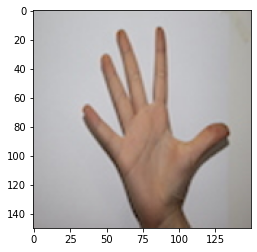

In [69]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import keras

model = keras.models.load_model("mimodelo.h5")

%matplotlib inline
pil_im = Image.open('./data/Sign-Language/5/IMG_1123.jpg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)
model.predict(im)

# Práctica

Se pide desarrollar una red neuronal para la clasificación de un conjunto de imágenes. Este conjunto puede ser creado por el propio alumno haciendo fotos de diferentes objetos en diferentes localizaciones y condiciones. Por ejemplo, libros, cubiertos de cocina, monedas, prendas de ropa… rollos de papel higiénico o lo que se tercie. El número recomendable de clases distintas será entre 4 y 7. Cada clase deberá tener un mínimo de 20 imágenes (cuantas más, mejor) para el conjunto de entrenamiento y 5 para el conjunto de validación. Una vez creado el *dataset* haremos lo siguiente:

-	Entrenar la red y visualizar gráficamente el progreso del *accuracy* tanto del conjunto de entrenamiento como del conjunto de validación. Para ello, se puede hacer uso del objeto <code>history</code> que devuelve el método <code>fit_generator</code> del modelo.


-	Hacer *data augmentation* sobre el conjunto de entrenamiento.


-	Probar con distintas configuraciones de hiperparámetros para escoger la que mejor resultados ofrezca.


-	*Categorical cross entropy* es una función de pérdida similar a la ya estudiada suma de diferencias al cuadrado. Explica cómo y por qué funciona esta función de pérdida.
